In [1]:
def crawl_sale_all(max_pages=50, scroll_pause=1.5, scroll_count=3):
    options = Options()
    options.add_argument("--window-size=1400,900")
    # options.add_argument("--headless=new")

    service = Service(ChromeDriverManager().install())

    all_data = []

    for page in range(1, max_pages + 1):

        driver = webdriver.Chrome(service=service, options=options)
        try:
            url = f"https://www.oliveyoung.co.kr/store/main/getSaleList.do?pageIdx={page}"
            driver.get(url)

            # 첫 상품이 뜰 때까지 대기
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "ul.cate_prd_list > li"))
                )
            except:
                break  # 더 이상 페이지 없음

            # 스크롤
            for _ in range(scroll_count):
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(scroll_pause)

            items = driver.find_elements(By.CSS_SELECTOR, "ul.cate_prd_list > li")
            print(f"{page}페이지 상품 개수:", len(items))

            # 더 이상 상품 없으면 종료
            if len(items) == 0:
                break

            for li in items:
                try:
                    name = li.find_element(By.CSS_SELECTOR, ".prd_name").text.strip()
                except:
                    continue

                try:
                    price = li.find_element(By.CSS_SELECTOR, ".tx_cur").text.strip()
                except:
                    price = None

                try:
                    orig_price = li.find_element(By.CSS_SELECTOR, ".tx_org").text.strip()
                except:
                    orig_price = None

                try:
                    url = li.find_element(
                        By.CSS_SELECTOR, "a[href*='goods/getGoodsDetail']"
                    ).get_attribute("href")
                except:
                    url = None

                all_data.append({
                    "page": page,
                    "name": name,
                    "price": price,
                    "orig_price": orig_price,
                    "url": url
                })

        finally:
            driver.quit()

    return pd.DataFrame(all_data)

In [ ]:
df_sale_all = crawl_sale_all()
print(df_sale_all.head())
print("총 개수:", len(df_sale_all))

df_sale_all.to_csv("oliveyoung_sale_all.csv", index=False)

#### 전처리

In [3]:
import pandas as pd

df_sale_all = pd.read_csv("./올영_세일.csv", encoding="utf-8")
print(df_sale_all.head())

   page                                               name       price  \
0     1  메디힐\n[2025 어워즈/14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 10+...    9,900원 ~   
1     1    일리윤\n[어워즈특가] 일리윤 세라마이드 아토 로션 600+334ML 어워즈 한정기획     24,500원   
2     1  에스트라\n[어워즈특가] 에스트라 아토베리어365 크림 80ml 어워즈 한정기획 (...     24,700원   
3     1  토리든\n[어워즈특가/1등 세럼] 토리든 다이브인 저분자 히알루론산 세럼 100ml...     33,250원   
4     1  메디큐브 에이지알\n[어워즈특가] 메디큐브 에이지알 부스터프로 미니플러스 짱구 에디...  115,900원 ~   

   orig_price                                                url  
0   20,000원 ~  https://www.oliveyoung.co.kr/store/goods/getGo...  
1     39,500원  https://www.oliveyoung.co.kr/store/goods/getGo...  
2     33,000원  https://www.oliveyoung.co.kr/store/goods/getGo...  
3     50,000원  https://www.oliveyoung.co.kr/store/goods/getGo...  
4  126,000원 ~  https://www.oliveyoung.co.kr/store/goods/getGo...  


In [4]:
import pandas as pd
import re

df = df_sale_all.copy()

def to_num(x):
    if x is None:
        return None
    x = str(x)
    x = x.replace("원", "").replace(",", "").replace("~", "").strip()
    return int(x) if x.isdigit() else None

df["price_num"] = df["price"].apply(to_num)
df["orig_price_num"] = df["orig_price"].apply(to_num)


df["brand"] = df["name"].apply(lambda x: str(x).split("\n")[0].split()[0])


df["discount_rate"] = (df["orig_price_num"] - df["price_num"]) / df["orig_price_num"]
df["discount_rate"] = df["discount_rate"].round(3)

#### 먼저 전처리(브랜드, 가격숫자, 할인율) 완료 코드

In [5]:
import pandas as pd
import re

df = df_sale_all.copy()


def to_num(x):
    if x is None:
        return None
    x = str(x)
    x = x.replace("원", "").replace(",", "").replace("~", "").strip()
    return int(x) if x.isdigit() else None

df["price_num"] = df["price"].apply(to_num)
df["orig_price_num"] = df["orig_price"].apply(to_num)


df["brand"] = df["name"].apply(lambda x: str(x).split("\n")[0].split()[0])


df["discount_rate"] = (
    (df["orig_price_num"] - df["price_num"]) / df["orig_price_num"]
).round(3)

df.head()

,page,name,price,orig_price,url,price_num,orig_price_num,brand,discount_rate
0,1,메디힐\n[2025 어워즈/14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 10+...,"9,900원 ~","20,000원 ~",https://www.oliveyoung.co.kr/store/goods/getGo...,9900,20000,메디힐,0.505
1,1,일리윤\n[어워즈특가] 일리윤 세라마이드 아토 로션 600+334ML 어워즈 한정기획,"24,500원","39,500원",https://www.oliveyoung.co.kr/store/goods/getGo...,24500,39500,일리윤,0.380
2,1,에스트라\n[어워즈특가] 에스트라 아토베리어365 크림 80ml 어워즈 한정기획 (...,"24,700원","33,000원",https://www.oliveyoung.co.kr/store/goods/getGo...,24700,33000,에스트라,0.252
3,1,토리든\n[어워즈특가/1등 세럼] 토리든 다이브인 저분자 히알루론산 세럼 100ml...,"33,250원","50,000원",https://www.oliveyoung.co.kr/store/goods/getGo...,33250,50000,토리든,0.335
4,1,메디큐브 에이지알\n[어워즈특가] 메디큐브 에이지알 부스터프로 미니플러스 짱구 에디...,"115,900원 ~","126,000원 ~",https://www.oliveyoung.co.kr/store/goods/getGo...,115900,126000,메디큐브,0.080


#### 브랜드별 등장 횟수 TOP 20

In [6]:
brand_count = df["brand"].value_counts().head(20)
brand_count

brand
메디힐      20
아누아      20
딜라이트     19
클리오      19
토리든      18
메디큐브     16
넘버즈인     16
아비브      16
닥터지      15
제로이드     15
라운드랩     14
바닐라코     14
바이오힐보    14
일리윤      14
달바       13
브링그린     13
롬앤       12
컬러그램     12
에스쁘아     12
바이오더마    12
Name: count, dtype: int64

#### 상품명 키워드 분석 (최빈 단어)

In [7]:
from collections import Counter
import re

all_text = " ".join(df["name"].tolist())

words = re.findall(r"[가-힣A-Za-z0-9]+", all_text)

words = [w for w in words if len(w) > 1]

Counter(words).most_common(50)

[('기획', 500),
 ('단품', 173),
 ('50ml', 122),
 ('어워즈특가', 120),
 ('어워즈', 116),
 ('증정', 116),
 ('한정기획', 109),
 ('택1', 98),
 ('크림', 90),
 ('세럼', 75),
 ('30ml', 72),
 ('NEW', 70),
 ('리필', 67),
 ('마스크', 62),
 ('100ml', 60),
 ('대용량', 56),
 ('200ml', 54),
 ('더블기획', 53),
 ('앰플', 52),
 ('2종', 52),
 ('단독기획', 50),
 ('더블', 48),
 ('3종', 46),
 ('틴트', 42),
 ('메디힐', 40),
 ('아누아', 40),
 ('패드', 38),
 ('딜라이트', 38),
 ('프로젝트', 38),
 ('클리오', 38),
 ('쿠션', 37),
 ('토리든', 36),
 ('선크림', 36),
 ('2입', 36),
 ('콜라겐', 35),
 ('4종', 34),
 ('수분', 33),
 ('메디큐브', 32),
 ('넘버즈인', 32),
 ('아비브', 32),
 ('에센스', 31),
 ('제로이드', 30),
 ('닥터지', 30),
 ('PICK', 29),
 ('6종', 29),
 ('일리윤', 28),
 ('라운드랩', 28),
 ('20ml', 28),
 ('미니', 28),
 ('바닐라코', 28)]

#### 세일가·정가·할인율 통계

In [9]:
df[["price_num", "orig_price_num", "discount_rate"]].describe()

,price_num,orig_price_num,discount_rate
count,1200.000000,1200.000000,1200.000000
mean,20850.725000,30062.575000,0.293615
std,27845.281997,39832.677784,0.118624
min,950.000000,1200.000000,0.010000
25%,11815.000000,17000.000000,0.208000
50%,18240.000000,26000.000000,0.280000
75%,25037.500000,36067.500000,0.362000
max,674100.000000,999000.000000,0.717000


#### 할인율 TOP 20 상품

In [8]:
top_discount = df.sort_values("discount_rate", ascending=False).head(20)
top_discount[["name", "brand", "price_num", "orig_price_num", "discount_rate", "url"]]

,name,brand,price_num,orig_price_num,discount_rate,url
987,정관장\n[12/5 하루특가][파격특가] 정관장 에브리타임 맥스/에너지 활기력 샷 ...,정관장,9900,35000,0.717,https://www.oliveyoung.co.kr/store/goods/getGo...
522,종근당건강\n프로메가 알티지 오메가3 듀얼 40 캡슐 더블 기획세트 (40일분),종근당건강,9900,29800,0.668,https://www.oliveyoung.co.kr/store/goods/getGo...
505,쏘피\n[반값특가]쏘피 안심숙면 팬티 10종 택 1(카카오프렌즈 3종/일반 7종),쏘피,3500,9600,0.635,https://www.oliveyoung.co.kr/store/goods/getGo...
1064,듀이트리\n[1일1팩/밀착진정] 듀이트리 AC 딥 진정 마스크 10매 (열감/흔적),듀이트리,11200,30000,0.627,https://www.oliveyoung.co.kr/store/goods/getGo...
534,"쏘피\n[99특가]쏘피 바디피트 볼록맞춤 4종 택 1 (중형16P, 대형16P, 슈...",쏘피,2590,6900,0.625,https://www.oliveyoung.co.kr/store/goods/getGo...
826,듀이트리\n[밀착진정] 듀이트리 AC 딥 진정 마스크 1매 (열감/흔적),듀이트리,1190,3000,0.603,https://www.oliveyoung.co.kr/store/goods/getGo...
707,식물나라\n[반값특가/착붙톤업]식물나라 뽀얀쌀 생기 톤업 선 쿠션 4종 택1 (리필...,식물나라,9900,24800,0.601,https://www.oliveyoung.co.kr/store/goods/getGo...
1179,리얼베리어\n리얼베리어 마스크 10매 3종 택1(장벽/수분/쿨링),리얼베리어,12000,30000,0.600,https://www.oliveyoung.co.kr/store/goods/getGo...
379,"좋은느낌\n[어워즈특가] 좋은느낌 오리지널 입는오버나이트 (S/M/L, 대용량)",좋은느낌,6900,17200,0.599,https://www.oliveyoung.co.kr/store/goods/getGo...
247,아누아\n[단독기획] 아누아 TXA 나이아신 흔적 세럼 30ml 2입,아누아,25850,64000,0.596,https://www.oliveyoung.co.kr/store/goods/getGo...


#### 카테고리 자동 분류 (키워드 기반 간단 버전)

In [10]:
def categorize(name):
    text = str(name)

    if any(k in text for k in ["크림", "로션", "세럼", "토너"]):
        return "스킨케어"
    if any(k in text for k in ["마스크", "팩"]):
        return "마스크팩"
    if any(k in text for k in ["클렌저", "폼", "클렌징"]):
        return "클렌징"
    if any(k in text for k in ["샴푸", "트리트먼트"]):
        return "헤어케어"
    if any(k in text for k in ["패드"]):
        return "패드"
    if any(k in text for k in ["부스터", "에센스"]):
        return "에센스/부스터"

    return "기타"

df["category"] = df["name"].apply(categorize)

df["category"].value_counts()

category
기타         594
스킨케어       325
마스크팩        97
클렌징         75
헤어케어        43
에센스/부스터     34
패드          32
Name: count, dtype: int64

#### 브랜드별 평균 가격/할인율 분석

In [11]:
brand_stats = df.groupby("brand")[["price_num", "orig_price_num", "discount_rate"]].mean()
brand_stats.sort_values("discount_rate", ascending=False).head(20)

,price_num,orig_price_num,discount_rate
brand,,,
정관장,9900.000000,35000.000000,0.717000
종근당건강,9900.000000,29800.000000,0.668000
비오템,40860.000000,98000.000000,0.583000
존바바토스,55800.000000,132000.000000,0.577000
딘시,12900.000000,30000.000000,0.570000
온더바디,5580.000000,12850.000000,0.567500
센텔리안24,22363.333333,51333.333333,0.556667
지오마,16200.000000,35000.000000,0.537000
리무브,18700.000000,40000.000000,0.532000


#### 그래프 시각화 – 할인율 히스토그램

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df.copy() 

sns.set(rc={"figure.figsize": (12, 6)})

In [15]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = fontprop.get_name()
plt.rcParams["axes.unicode_minus"] = False

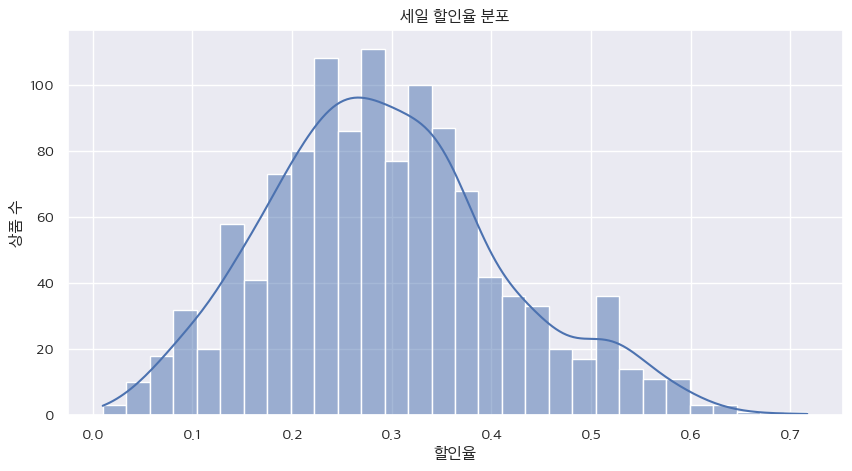

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df["discount_rate"].dropna(), bins=30, kde=True)
plt.title("세일 할인율 분포")
plt.xlabel("할인율")
plt.ylabel("상품 수")
plt.show()

#### 브랜드 할인율 랭킹 (평균 할인율 TOP 20)

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_18121/3082701343.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


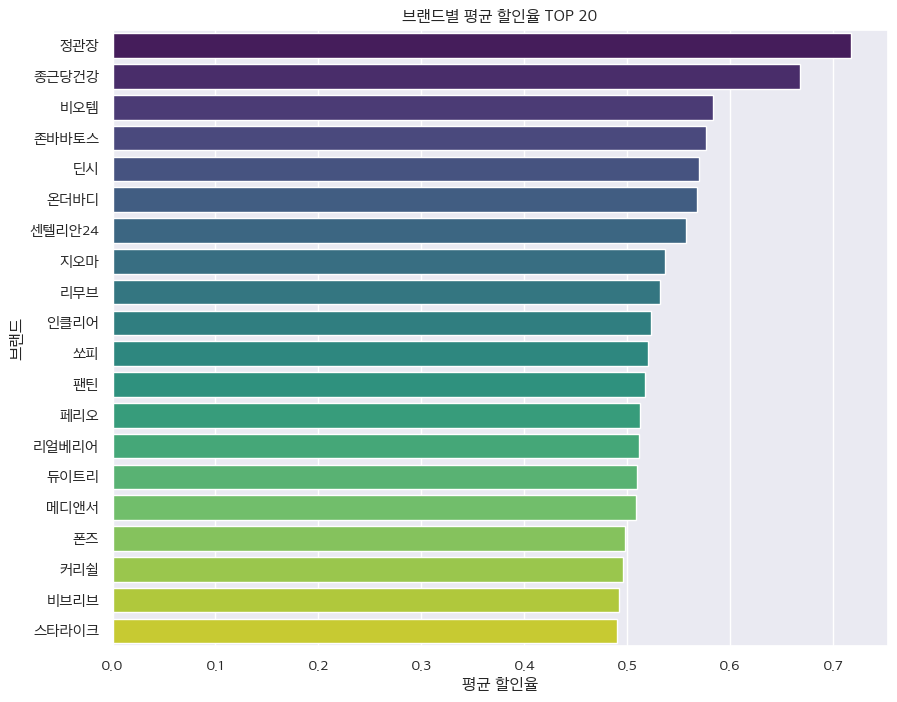

brand
정관장       0.717000
종근당건강     0.668000
비오템       0.583000
존바바토스     0.577000
딘시        0.570000
온더바디      0.567500
센텔리안24    0.556667
지오마       0.537000
리무브       0.532000
인클리어      0.523000
쏘피        0.520000
팬틴        0.517000
페리오       0.512500
리얼베리어     0.511000
듀이트리      0.509200
메디앤서      0.509000
폰즈        0.497500
커리쉴       0.496000
비브리브      0.492000
스타라이크     0.490000
Name: discount_rate, dtype: float64

In [17]:
brand_discount = (
    df.groupby("brand")["discount_rate"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10,8))
sns.barplot(
    x=brand_discount.values,
    y=brand_discount.index,
    palette="viridis"
)
plt.title("브랜드별 평균 할인율 TOP 20")
plt.xlabel("평균 할인율")
plt.ylabel("브랜드")
plt.show()

brand_discount

#### 가격대 분포 (세일가 기준)

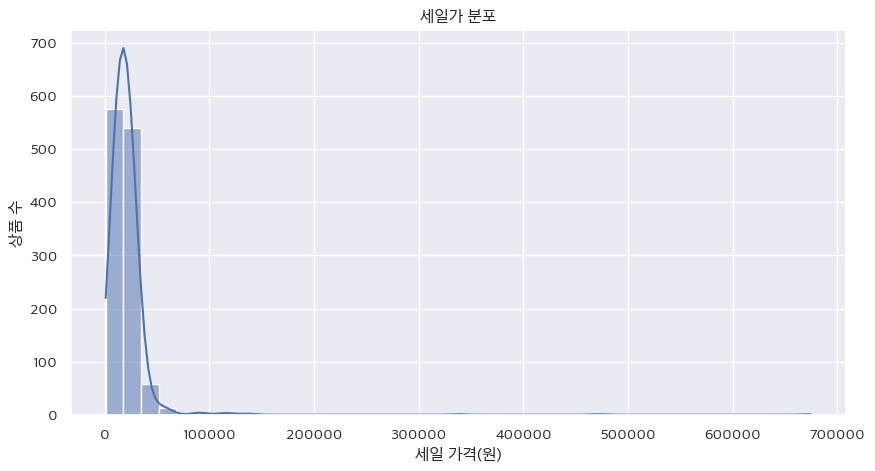

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(df["price_num"].dropna(), bins=40, kde=True)
plt.title("세일가 분포")
plt.xlabel("세일 가격(원)")
plt.ylabel("상품 수")
plt.show()

#### 카테고리별 평균 할인율 비교

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_18121/2914871286.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


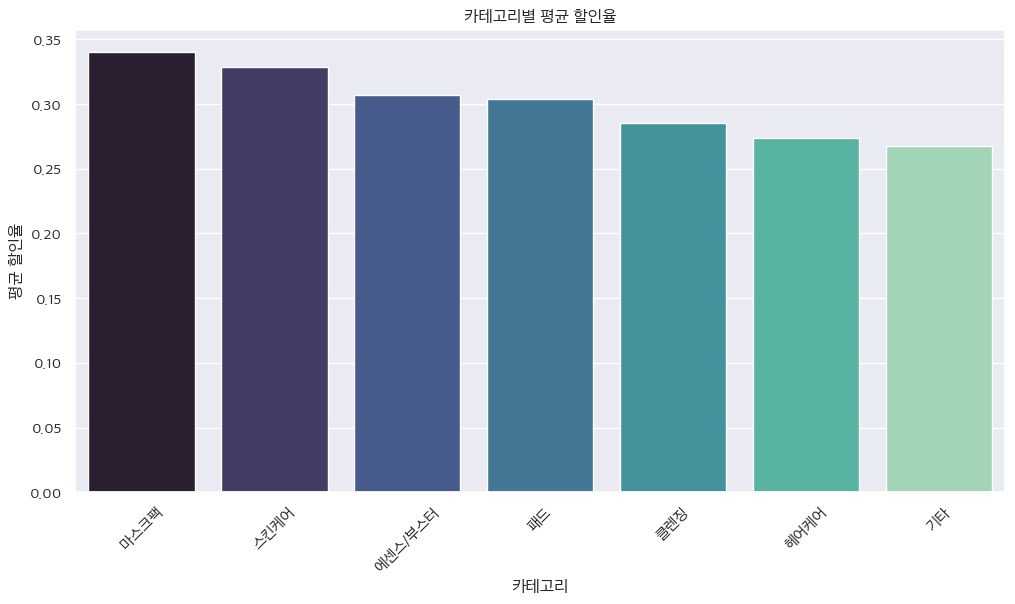

category
마스크팩       0.340134
스킨케어       0.329062
에센스/부스터    0.306735
패드         0.303969
클렌징        0.285587
헤어케어       0.274116
기타         0.267741
Name: discount_rate, dtype: float64

In [19]:
cat_discount = (
    df.groupby("category")["discount_rate"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=cat_discount.index,
    y=cat_discount.values,
    palette="mako"
)
plt.title("카테고리별 평균 할인율")
plt.xlabel("카테고리")
plt.ylabel("평균 할인율")
plt.xticks(rotation=45)
plt.show()

cat_discount

#### 할인율과 판매순위의 상관관계

In [20]:
df["rank"] = df.index + 1

##### 피어슨 상관계수 계산

In [22]:
corr = df["discount_rate"].corr(df["rank"])
corr

np.float64(-0.007444927032919538)

######	corr < 0 → 할인율이 높을수록 판매순위가 높다(잘 팔린다)
######  corr ≈ 0 → 거의 상관없다
######  corr > 0 → 할인율이 높을수록 판매순위가 낮아진다(잘 안 팔린다)